In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
depth=np.load('depth.npy')

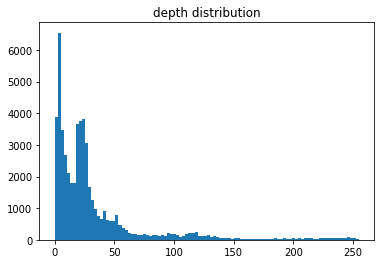

In [3]:
depth_1d = depth.flatten()
depth_1d = np.interp(depth_1d, (depth_1d.min(), depth_1d.max()), (0,255))
plt.hist(depth_1d, bins=100)
plt.gca().set(title='depth distribution')
plt.show()

In [4]:
depth_rescaled = np.reshape(depth_1d, depth.shape)
depth_rescaled = depth_rescaled.astype(np.uint8)

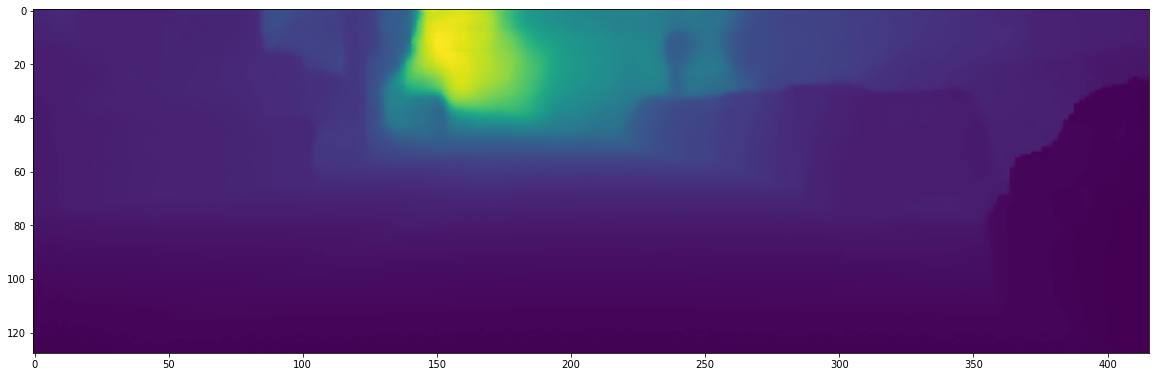

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(np.squeeze(depth_rescaled))

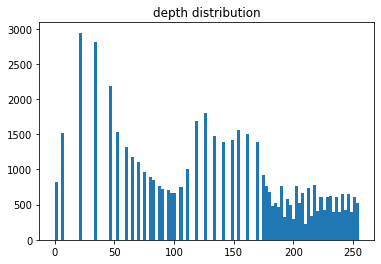

In [6]:
depth_1d = depth_rescaled.flatten()
# depth_norm = None# np.empty_like(depth_1d)
depth_norm=cv.equalizeHist(depth_1d)
plt.hist(depth_norm, bins=100)
plt.gca().set(title='depth distribution')
plt.show()

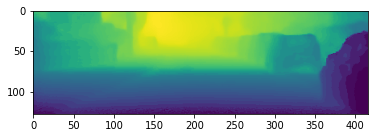

In [7]:
depth_rescaled = np.reshape(depth_norm, depth.shape)
plt.imshow(np.squeeze(depth_rescaled))

In [10]:
cv.imwrite('drive_depth_norm.png', depth_rescaled)

True

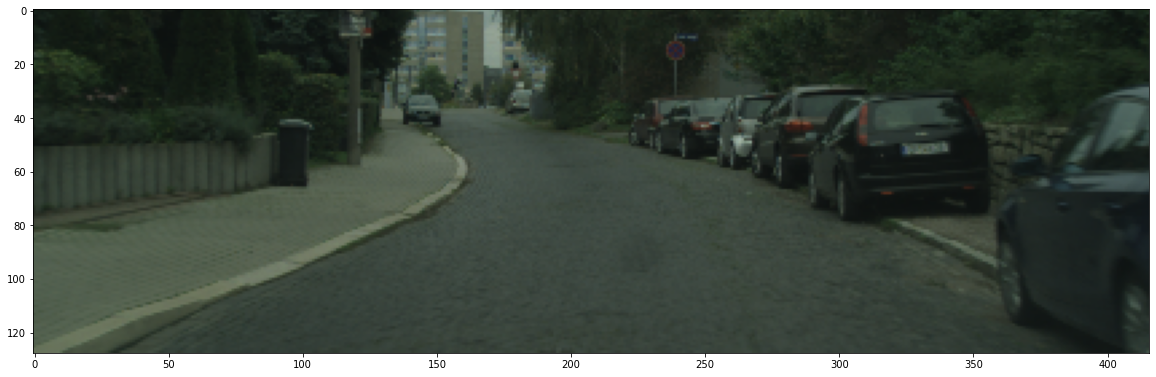

In [43]:
img=cv.cvtColor(cv.imread('drive.png'), cv.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)

In [1]:
import open3d as o3d
import numpy as np

In [3]:
# load input file
output_path="your_path_to_output_folder/"
pcl_input_file="sample.xyz"
point_cloud= np.loadtxt(pcl_input_file,skiprows=1)

In [4]:
# transform from numpy matrix to o3d object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(point_cloud[:,3:6]/255)
# pcd.normals = o3d.utility.Vector3dVector(point_cloud[:,6:9])

In [4]:
o3d.visualization.draw_geometries([pcd])

In [5]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
dec_mesh = mesh.simplify_quadric_decimation(100000)

RuntimeError: [1;31m[Open3D ERROR] ReconstructBallPivoting requires normals[0;m

In [2]:
color_raw = o3d.io.read_image("drive.png")
depth_raw =  o3d.io.read_image("drive_depth_norm.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)

RGBDImage of size 
Color image : 416x128, with 1 channels.
Depth image : 416x128, with 1 channels.
Use numpy.asarray to access buffer data.


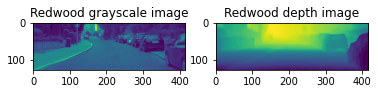

In [14]:
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [3]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
# o3d.visualization.draw_geometries([pcd])

geometry::PointCloud with 52430 points.

In [ ]:
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd])

# distances = pcd.compute_nearest_neighbor_distance()
# avg_dist = np.mean(distances)
# radius = 3 * avg_dist
# pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30))
# bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
# # dec_mesh = mesh.simplify_quadric_decimation(100000)

# o3d.visualization.draw_geometries([pcd, rec_mesh])

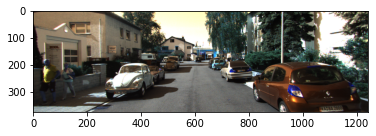

In [11]:
im=cv.imread('/Users/akshitjain/ext/workspace/datasets/kitti_2012/2011_09_26/2011_09_26_drive_0035_sync/image_02/data/0000000000.png')
plt.imshow(im)
plt.show()

In [10]:
dst_sz=np.array([416, 128])
src_sz=np.array([im.shape[1], im.shape[0]])
np.divide(src_sz,dst_sz)

array([2.98557692, 2.9296875 ])

(128, 416)


In [18]:
from depth_evaluation_utils import *

In [23]:
kitti_dir = '/Users/akshitjain/ext/workspace/datasets/kitti_2012/2011_09_26/2011_09_26_drive_0035_sync'
camera_id = 2
gt_file, gt_calib, im_size, im_file, _ = read_file_data(
    kitti_base_dir=kitti_dir, cam=camera_id)
gt_depth_sparse = generate_depth_map(gt_calib,
                                  gt_file,
                                  im_size,
                                  camera_id,
                                  interp=False,
                                  vel_depth=True)

In [48]:
pred_depth = np.load('../data/0000000000_depth.npy')
pred_depth_resized=cv2.resize(pred_depth, (gt_depth_sparse.shape[1], gt_depth_sparse.shape[0]), interpolation=cv2.INTER_LINEAR)

In [49]:
gt_depth=gt_depth_sparse
pred_depth=pred_depth_resized
min_depth=1e-3
max_depth=80

mask = np.logical_and(gt_depth > min_depth, 
                      gt_depth < max_depth)
scalor = np.median(gt_depth[mask])/np.median(pred_depth[mask])
pred_depth[mask] *= scalor
pred_depth[pred_depth < min_depth] = min_depth
pred_depth[pred_depth > max_depth] = max_depth

In [50]:
# error percentage
depth_errors=np.abs(pred_depth[mask] / gt_depth[mask] - 1)*100

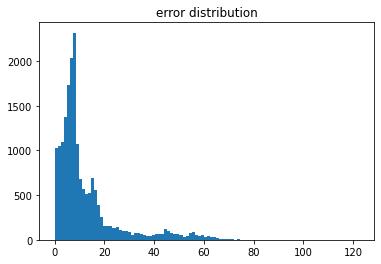

In [51]:
plt.hist(depth_errors, bins=100)
plt.gca().set(title='error distribution')
plt.show()

In [42]:
abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3 = compute_errors(gt_depth[mask], pred_depth[mask])

In [44]:
print(abs_rel)

0.12419387544684973


In [47]:
print(np.median(gt_depth[mask]), np.median(pred_depth[mask]))

11.274499893188477 11.2745


In [64]:
err_img = np.zeros_like(gt_depth)
depth_errors_norm=np.interp(depth_errors, (depth_errors.min(), depth_errors.max()), (0,255)).astype(np.uint8)
depth_errors_norm = cv.equalizeHist(depth_errors_norm.flatten())
err_img[mask] = np.squeeze(depth_errors_norm)

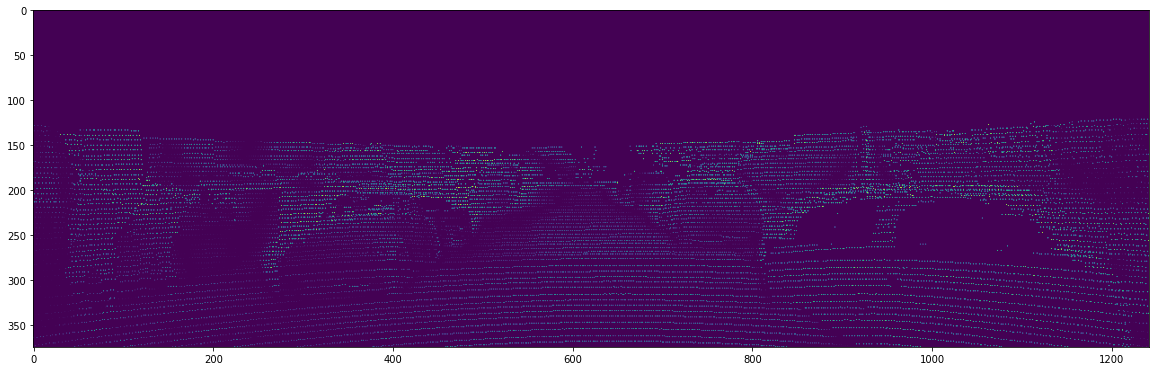

In [69]:
plt.figure(figsize=(20,10))
plt.imshow(err_img.astype(np.uint8))

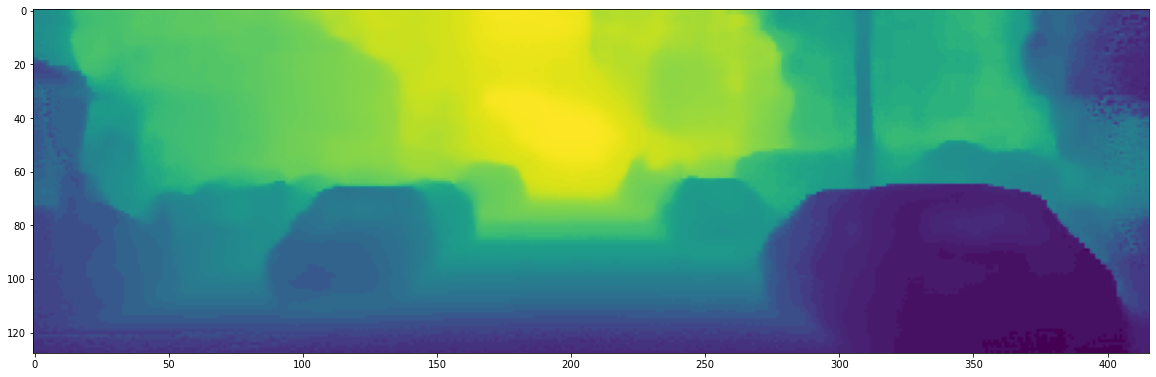

In [79]:
def scale_depth_range(depth):
    depth = np.interp(depth, (depth.min(), depth.max()),
                      (0, 255)).astype(np.uint8)
    return depth

def normalize_depth_distribution(depth):
    im_shape = depth.shape
    depth=scale_depth_range(depth)
    depth_norm = cv.equalizeHist(depth.flatten())
    return np.reshape(scale_depth_range(depth_norm), im_shape)

plt.figure(figsize=(20,10))
pred_depth = np.squeeze(np.load('../data/0000000000_depth.npy'))
plt.imshow(normalize_depth_distribution(pred_depth))

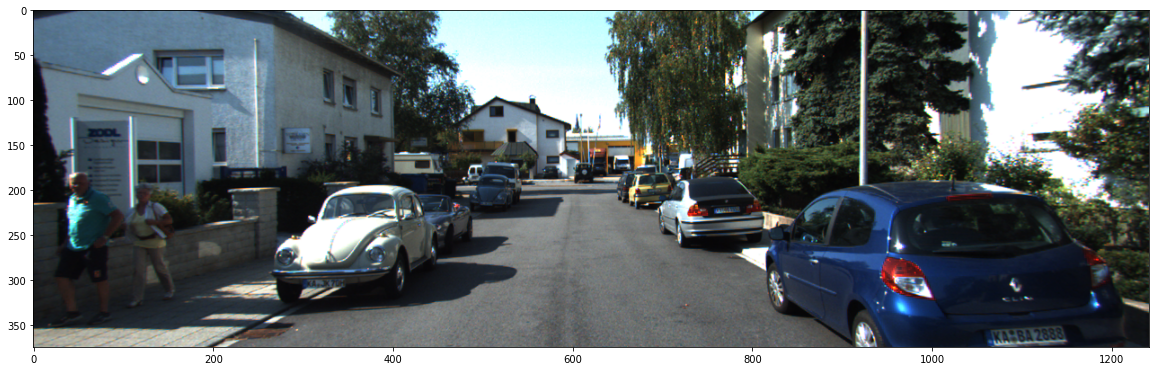

In [83]:
im=cv.imread('/Users/akshitjain/ext/workspace/datasets/kitti_2012/2011_09_26/2011_09_26_drive_0035_sync/image_02/data/0000000000.png')
plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.show()